Import python libraries:

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

Define function to pull ticker price history:

In [3]:
def get_ticker_history(ticker):

    stock = yf.Ticker(ticker)
    stock.info
    history = stock.history(period="1mo")

    df = pd.DataFrame(history)
    df.reset_index(inplace=True)
    
    #drop unwanted columns
    df.drop(['High','Low','Dividends','Stock Splits'], axis=1, inplace=True)

    #rename columns
    df.rename(columns={'Open': 'open_price', 'Close': 'close_price', 'Volume': 'volume'}, inplace=True)

    #clean up columns
    df['open_price'] = np.round(df['open_price'],2)
    df['close_price'] = np.round(df['close_price'],2)
    df['date_numeric'] = df.index + 1
    df['date'] = (df['Date']).dt.date

    #calculate new columns
    df['ticker'] = f'{ticker}'
    df['price_delta'] = df['close_price'] - df['open_price']

    #return desired columns
    df = df[['ticker', 'open_price', 'close_price', 'price_delta', 'date', 'date_numeric']]

    return(df)

Print the first few rows of our dataframe:

In [4]:
ex_table = get_ticker_history("NVDA")
print(ex_table.head(5))

  ticker  open_price  close_price  price_delta        date  date_numeric
0   NVDA      719.44       694.49       -24.95  2024-02-20             1
1   NVDA      680.03       674.69        -5.34  2024-02-21             2
2   NVDA      750.21       785.34        35.13  2024-02-22             3
3   NVDA      807.86       788.13       -19.73  2024-02-23             4
4   NVDA      796.96       790.88        -6.08  2024-02-26             5


Plot the data in our dataframe:

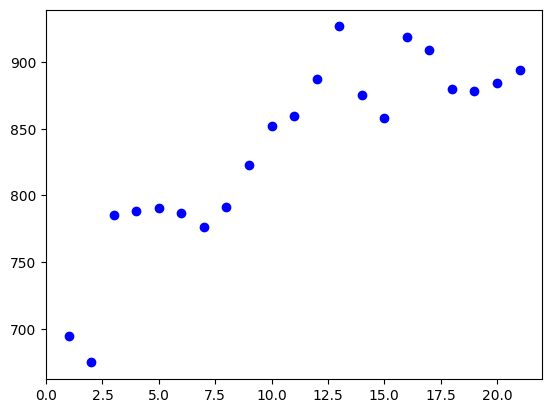

In [16]:
df = get_ticker_history("NVDA")
plt.scatter(df['date_numeric'], df['close_price'], label='Original Data', color='blue')
plt.show()

Here's what the fitted curve looks like visually:

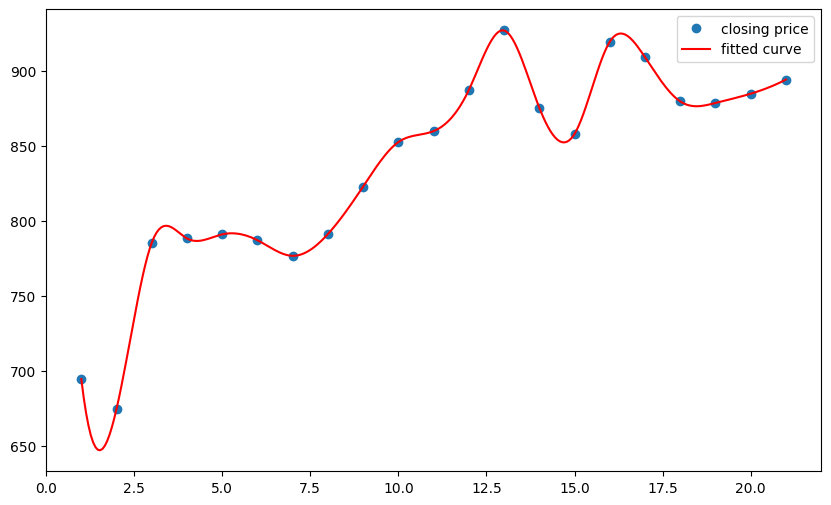

In [17]:
df = get_ticker_history("NVDA")

x = df['date_numeric']
y = df['close_price']

spline = UnivariateSpline(x, y, s=0, k=3)

x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x_smooth)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='closing price')  # Original data points
plt.plot(x_smooth, y_smooth, '-', label='fitted curve', color='red')  # Smooth curve
plt.legend()
plt.show()

Create a new function to calculate the 2nd derivative of fitted curve at each closing price:

In [18]:

def calculate_d2ydx2(ticker):
    
    df = get_ticker_history(ticker)
    spline = UnivariateSpline(df['date_numeric'], df['close_price'], s=0, k=3)
    df['d2ydx2'] = spline.derivative(n=2)(df['date_numeric'])    
    df = (df[['ticker','date','close_price','d2ydx2','date_numeric']])

    return(df)

Now we've got the 2nd derivative at each closing price:

In [19]:
ex_table = calculate_d2ydx2("NVDA")
ex_table = ex_table.sort_values(by='date_numeric', ascending=False)

print(ex_table.head(5))

   ticker        date  close_price     d2ydx2  date_numeric
20   NVDA  2024-03-19       893.98   7.411780            21
19   NVDA  2024-03-18       884.55   3.250000            20
18   NVDA  2024-03-15       878.37  -0.911780            19
17   NVDA  2024-03-14       879.44  43.897120            18
16   NVDA  2024-03-13       908.88  -4.456701            17


Generate a buy or sell signal based on the current second derivative in the function:

In [20]:
def generate_signal(ticker):

    df = calculate_d2ydx2(ticker)
    date_current = df['date_numeric'].max()

    result = df.loc[df['date_numeric'] == date_current, 'd2ydx2'].item()

    if result > 0:
        print("Buy, d2ydx2: ", result)
    else:
        print("Sell, d2ydx2: ", result)

Test our function:

In [21]:
generate_signal('NVDA')

Buy, d2ydx2:  7.411780046523461
